<a href="https://colab.research.google.com/github/jvallalta/ia-medicina/blob/main/VAE_Imagenes_RX_Torax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders variacionales con imágenes de RX Tórax

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from google.colab import drive

In [3]:
# Leemos el conjunto RSNA del drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Rutas
train = '/content/drive/MyDrive/rsna/stage_2_train_images'
test = '/content/drive/MyDrive/rsna/stage_2_test_images'
ruta = '/content/drive/MyDrive/rsna'

In [5]:
# Cargamos el fichero con metadatos
imagenes = pd.read_csv(ruta+'/stage_2_detailed_class_info.csv')
imagenes.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [6]:
# Separamos imágenes pacientes sanos de imágenes de pacientes con anomalias
normales = imagenes[imagenes['class']=='Normal']
anormales = imagenes[imagenes['class']!='Normal']

In [7]:
#Tamaños
print(normales.shape)
print(anormales.shape)

(8851, 2)
(21376, 2)


In [8]:
#Definimos función lectura dicom
!pip install pydicom
import pydicom

In [9]:
#Función lectura imagen
def leer_dicom(imagen):
  ds = pydicom.dcmread(imagen)
    
  img = ds.pixel_array
  view = ds.ViewPosition
  sexo = ds.PatientSex
  edad = ds.PatientAge
  return img, view, sexo, edad

AP
F
34


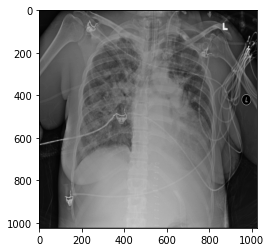

In [13]:
# Probamos lectura de la imagen
prueba ='/content/drive/MyDrive/rsna/stage_2_train_images/02099738-7465-4786-b71c-de8cdac477c3.dcm'
imagen, vista, sexo, edad = leer_dicom(prueba)
plt.imshow(imagen, cmap='gray')
print(vista)
print(sexo)
print(edad)

In [39]:
# Creamos dataframe con datos de pacientes normales
#pacientes_normales = pd.DataFrame(columns=('id_paciente', 'vista', 'sexo', 'edad'))
#for contador in range(len(normales)):
#  _, vista, sexo, edad = leer_dicom(train + '/' + normales.iloc[contador,0] + '.dcm')
#  pacientes_normales.loc[len(pacientes_normales)]=[normales.iloc[contador,0], vista, sexo, edad]

In [15]:
#Leemos dataframe con los datos pacientes normales
pacientes_normales = pd.read_csv(ruta + '/pacientes_normales.csv')
pacientes_normales.head()

,Unnamed: 0,id_paciente,vista,sexo,edad
0,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28
1,1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63
2,2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54
3,3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48
4,4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36


In [41]:
pacientes_normales.to_csv(ruta + '/pacientes_normales.csv')

In [16]:
# Nos quedamos con las imágenes con vista PA (Posteroanterior)
normales_PA = pacientes_normales[pacientes_normales['vista']=='PA']
normales_PA.shape

(7214, 5)

In [27]:
normales_PA['ruta']=''
for contador in range(len(normales_PA)):
  normales_PA.iloc[contador,-1] = train + '/' + normales_PA.iloc[contador,1] + '.dcm'
print(normales_PA['ruta'].head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0    /content/drive/MyDrive/rsna/stage_2_train_imag...
1    /content/drive/MyDrive/rsna/stage_2_train_imag...
2    /content/drive/MyDrive/rsna/stage_2_train_imag...
3    /content/drive/MyDrive/rsna/stage_2_train_imag...
4    /content/drive/MyDrive/rsna/stage_2_train_imag...
Name: ruta, dtype: object


In [43]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda
Wed Feb 24 23:17:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [72]:
class RSNA(Dataset):
    """RSNA dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ruta_imagen = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.ruta_imagen)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.ruta_imagen.iloc[idx, 6]
        ds = pydicom.dcmread(img_name)
        image = ds.pixel_array
        image = 
        

        if self.transform:
            image = self.transform(image)

        return image

In [62]:
normales_PA.to_csv(ruta + '/normales_PA.csv')

In [73]:
rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train)


In [74]:
rsna_dataset.ruta_imagen

,Unnamed: 0,Unnamed: 0.1,id_paciente,vista,sexo,edad,ruta
0,0,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28,/content/drive/MyDrive/rsna/stage_2_train_imag...
1,1,1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63,/content/drive/MyDrive/rsna/stage_2_train_imag...
2,2,2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54,/content/drive/MyDrive/rsna/stage_2_train_imag...
3,3,3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48,/content/drive/MyDrive/rsna/stage_2_train_imag...
4,4,4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36,/content/drive/MyDrive/rsna/stage_2_train_imag...
...,...,...,...,...,...,...,...
7209,8845,8845,c1c3ec5d-20ba-42f7-91f9-48032d97ffc9,PA,F,26,/content/drive/MyDrive/rsna/stage_2_train_imag...
7210,8846,8846,c1ca4417-83a6-43a7-a9bf-7d9587e7f14f,PA,M,33,/content/drive/MyDrive/rsna/stage_2_train_imag...
7211,8847,8847,c1cf3255-d734-4980-bfe0-967902ad7ed9,PA,F,27,/content/drive/MyDrive/rsna/stage_2_train_imag...
7212,8849,8849,c1edf42b-5958-47ff-a1e7-4f23d99583ba,PA,F,46,/content/drive/MyDrive/rsna/stage_2_train_imag...


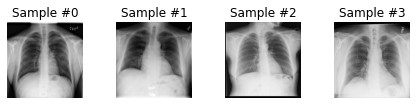

In [84]:
rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train)

fig = plt.figure()

for i in range(len(rsna_dataset)):
    sample = rsna_dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample, cmap='gray')
    
    if i == 3:
        plt.show()
        break

In [143]:
batch_size=16

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(64),
                                transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

trainloader = torch.utils.data.DataLoader(rsna_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

[[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99215686
  -1.        ]
 ...
 [ 0.04313731  0.12941182  0.27058828 ... -0.7882353  -0.9764706
  -1.        ]
 [ 0.13725495  0.254902    0.38823533 ... -0.58431375 -0.8509804
  -0.9764706 ]
 [ 0.35686278  0.47450984  0.5921569  ... -0.21568626 -0.5137255
  -0.7882353 ]]
(64, 64)
(64, 64)


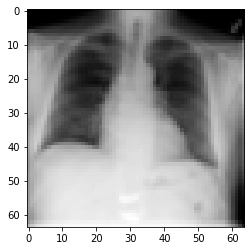

In [144]:
# Grab a sample image
import random

idx = random.randint(0,10)
tensor = rsna_dataset[idx]
image = np.squeeze(tensor.numpy())
print(image)
print(image.shape)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
print(image.shape)
#image = image.transpose((1, 2, 0))
plt.imshow(image, cmap='gray')

In [140]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=8, kernel_size=3
        )
        self.enc2 = nn.Conv2d(
            in_channels=8, out_channels=4, kernel_size=3
        )
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=4, out_channels=8, kernel_size=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=8, out_channels=1, kernel_size=3
        )
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        return x

model = Autoencoder().to(device)
print(model)

Autoencoder(
  (enc1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (enc2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
  (dec1): ConvTranspose2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [141]:
#Loss function
criterion = nn.MSELoss() # BinaryCrossEntropy

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [145]:
NUM_EPOCHS=2
train_loss = []
model.train()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in trainloader:
        img = data # no need for the labels
        img = img.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*img.size(0)
        
    loss = running_loss / len(trainloader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, NUM_EPOCHS, loss))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5ff4a3440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5ff4a3440>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5ff4a3440>
  File "/usr/local/lib/python3.7/dist-

Epoch 1 of 2, Train Loss: 2.337


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5ff4a3440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5ff4a3440>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5ff4a3440>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7

Epoch 2 of 2, Train Loss: 2.305


In [90]:
trainloader

In [138]:
dataiter = iter(trainloader)
dataiter.next().shape

torch.Size([32, 1, 128, 128])

In [ ]:
z = torch.randn(1, 20).to(device)
# run only the decoder
reconstructed_img = model.dec(z)
#reconstructed_img = reconstructed_img.cpu().numpy()

#output = model(images)
#images = images.cpu().numpy()
img = reconstructed_img.view(224, 224).data
img = img.cpu().detach().numpy()
#img = reconstructed_img .view(batch_size, 3, 32, 32)
#img = img.cpu().detach().numpy()

#output = output.view(batch_size, 3, 32, 32)
#output = output.cpu().detach().numpy()
#img = reconstructed_img.view(224, 224).data
print(z.shape)
print(img.shape)
plt.imshow(img,cmap='gray')